A.S. Lundervold, 080223

# Introduction

A quick demo of model ensembling using the "Gradio Pets" example from the 2022 fastai course: https://huggingface.co/spaces/jph00/pets/tree/main. (Jeremy Howard's training notebook is rendered [here](https://nbviewer.org/urls/huggingface.co/spaces/jph00/pets/resolve/main/train.ipynb)). 

See also the experiments by J. Howard and T. Capelle here for information about which models tend to work best: https://www.kaggle.com/code/jhoward/which-image-models-are-best/

> The notebook is also available on Kaggle: https://www.kaggle.com/code/alexanderlundervold/model-ensembling-with-fastai-and-timm/edit

# Setup

In [1]:
try:
    import colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
%%capture
if (colab or kaggle):
    !pip3 install -U fastai
    !pip3 install timm

In [3]:
import timm
from fastai.vision.all import *

# Dataloaders

In [4]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(224))

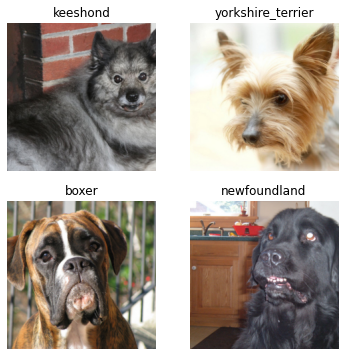

In [5]:
dls.show_batch(max_n=4)

# Train a baseline model

We train a ResNet18 model to verify that things are set up correctly and to get a rough estimate of what performance to expect:

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.574067,0.396687,0.116373,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.478451,0.307970,0.092016,01:15


Free up (some) GPU memory:

In [7]:
import gc
del learn
gc.collect()
torch.cuda.empty_cache()

# TIMM models

In [8]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [9]:
timm.list_models('swin*')

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_s3_base_224',
 'swin_s3_small_224',
 'swin_s3_tiny_224',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224',
 'swinv2_base_window8_256',
 'swinv2_base_window12_192_22k',
 'swinv2_base_window12to16_192to256_22kft1k',
 'swinv2_base_window12to24_192to384_22kft1k',
 'swinv2_base_window16_256',
 'swinv2_cr_base_224',
 'swinv2_cr_base_384',
 'swinv2_cr_base_ns_224',
 'swinv2_cr_giant_224',
 'swinv2_cr_giant_384',
 'swinv2_cr_huge_224',
 'swinv2_cr_huge_384',
 'swinv2_cr_large_224',
 'swinv2_cr_large_384',
 'swinv2_cr_small_224',
 'swinv2_cr_small_384',
 'swinv2_cr_small_ns_224',
 'swinv2_cr_tiny_224',
 'swinv2_cr_tiny_384',
 'swinv2_cr_tiny_ns_224',
 'swinv2_large_window12_192_22

In [10]:
architectures_to_test = [
    "convnext_tiny_in22k",
    "convnext_small_in22k",
    "swin_s3_tiny_224"
]

In [11]:
def train_model(arch, epochs=2, savefn=None):
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs)
    
    if savefn:
        learn.export(f"{savefn}.pkl")
        
    # Garbage collection (we don't want to store the learner in memory)
    del learn
    gc.collect()
    torch.cuda.empty_cache()
    
    return None

In [12]:
for arch in architectures_to_test:
    print(arch)
    learn = train_model(arch, epochs=1)   
    print("#"*40)

convnext_tiny_in22k


epoch,train_loss,valid_loss,error_rate,time
0,1.136984,0.252846,0.087957,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.281935,0.192510,0.061570,01:25


########################################
convnext_small_in22k


epoch,train_loss,valid_loss,error_rate,time
0,1.018128,0.211965,0.074425,01:28


epoch,train_loss,valid_loss,error_rate,time
0,0.233765,0.154246,0.049391,01:39


########################################
swin_s3_tiny_224


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,error_rate,time
0,1.167750,0.225315,0.069689,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.306868,0.176204,0.058187,01:28


########################################


# Ensembling

The above experiments with a few of the architectures lead to the following shortlisted ones (one can, of course, probably find more and perhaps better models through more extensive experiments): 

In [13]:
architectures = [
    "convnext_tiny_in22k",
    "convnext_small_in22k",
    "swin_s3_tiny_224"
]

In [14]:
for arch in architectures:
    print(arch)
    train_model(arch, epochs=2, savefn=arch)
    print("#"*40)

convnext_tiny_in22k


epoch,train_loss,valid_loss,error_rate,time
0,1.089521,0.234197,0.082544,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.263017,0.204036,0.062923,01:26
1,0.168689,0.175839,0.056157,01:27


########################################
convnext_small_in22k


epoch,train_loss,valid_loss,error_rate,time
0,1.019516,0.207607,0.066982,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.246218,0.182648,0.057510,01:40
1,0.156673,0.144667,0.041272,01:39


########################################
swin_s3_tiny_224


epoch,train_loss,valid_loss,error_rate,time
0,1.241543,0.218732,0.066982,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.312502,0.213576,0.060217,01:28
1,0.216211,0.171306,0.054804,01:28


########################################


Here are the trained models:

In [15]:
if kaggle:
    models = list(Path('/kaggle/working/').glob("*.pkl"))
else:
    models = list(Path('.').glob("*.pkl"))
    
print(models)

[Path('/kaggle/working/convnext_tiny_in22k.pkl'), Path('/kaggle/working/convnext_small_in22k.pkl'), Path('/kaggle/working/swin_s3_tiny_224.pkl')]


We collect all the probabilities assigned by the models to each validation instance:

In [16]:
all_probs = []
for i, model in enumerate(models):

    learn = load_learner(model, cpu=False)
    learn.dls = dls

    print(f"Getting predictions from model #{i+1}/{len(models)} ")
    probs, preds = learn.get_preds(dl=learn.dls.valid)
    all_probs.append(probs)
    
    del learn
    gc.collect()
    torch.cuda.empty_cache()
    

Getting predictions from model #1/3 


Getting predictions from model #2/3 


Getting predictions from model #3/3 


Averaging this (i.e., _soft voting_) gives us ensemble predictions:

In [17]:
all_probs = torch.stack(all_probs, dim=0)

In [18]:
all_probs.shape

torch.Size([3, 1478, 37])

In [19]:
mean = all_probs.mean(axis=0)

In [20]:
mean.shape

torch.Size([1478, 37])

In [21]:
preds = np.uint8(mean.argmax(dim=1))

In [22]:
preds.shape

(1478,)

In [23]:
labels = [int(l) for img, l in dls.valid.dataset]

**Error rate of ensemble:**

In [24]:
1- (preds == labels).sum() / len(labels)

0.04059539918809196

> Better than each individual model.